# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import KBinsDiscretizer,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [2]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
countries = pd.read_csv("countries.csv")

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.

In [6]:
# Informações sobre o dataframe:
exploration = pd.DataFrame({'type': countries.dtypes,
                            'amount': countries.isna().sum(),
                            'percentage': (countries.isna().sum() / countries.shape[0]) * 100,
                            'unique values': countries.nunique()})
                            

exploration

,type,amount,percentage,unique values
Country,object,0,0.000000,227
Region,object,0,0.000000,11
Population,int64,0,0.000000,227
Area,int64,0,0.000000,226
Pop_density,object,0,0.000000,219
Coastline_ratio,object,0,0.000000,151
Net_migration,object,3,1.321586,157
Infant_mortality,object,3,1.321586,220
GDP,float64,1,0.440529,130
Literacy,object,18,7.929515,140


In [7]:
def data_transformation(df):
    """Adjusting the data set."""

    # Alterando o separador decimal e convertendo as variáveis em numéricas:
    df.iloc[0:, 4:] = df.iloc[0:, 4:].replace(',', '.', regex=True).astype(float)

    # Removendo os espaços em branco no começo e no final da string:
    df = df.applymap(lambda x: x.strip() if type(x)==str else x)
    return df

# Chamando a função:
countries = data_transformation(countries)

Uma maneira fácil de alterar o separador seria usando o parâmetro **decimal** do pd.read_csv no momento da leitura do arquivo. Exemplo: ```countries = pd.read_csv("countries.csv", decimal=',')```. Como o notebook já veio com a leitura feita decidi usar outra abordagem para resolver esse problema.

In [8]:
# Visualizando os dados depois das alterações:
countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [9]:
def q1():
   """Ordered list with the unique values ​​of the 'Region' column."""

   return sorted(countries['Region'].unique())
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [11]:
def q2():
    """Transform the variable with KBinsDiscretizer."""

    # Configurando o discretizador:
    discretize = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

    # Ajustando e transformando os dados:
    answer = discretize.fit_transform(countries[['Pop_density']])

    # Número de países que estão acima de 90º percentil:
    return int((answer >= 9).sum())
q2()

23

A Discretização é o processo pelo qual podemos transformar variáveis contínuas em uma forma discreta. Os dados contínuos são medidos, enquanto os dados discretos são contados.

* **n_bins:** Número de intervalos. 
* **encode='ordinal':** Retorna o resultado codificado como um valor inteiro.
* **strategy='quantile':** Cada bins tem aproximadamente o mesmo número de amostras.

Para mais detalhes sobre essas informações consulte a [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html).

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [13]:
def q3():
    """Applying one-hot-encoding."""

    # Número de novos atributos:
    return pd.get_dummies(countries[['Region','Climate']]).shape[1] + countries[['Climate']].nunique()[0]
q3()

18

Quando usamos o **get_dummies()** o pandas por padrão executa a codificação one-hot encoding. 

O **one-hot encoding** é um processo pelo qual variáveis ​​categóricas são convertidas em um formato que pode ser fornecido aos algoritmos de ML para fazer um trabalho melhor na previsão.

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [14]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [15]:
def q4():
    """Using the pipeline to chain multiple transformation tasks."""

    # Selecionando só as colunas numéricas:
    num_features = countries.select_dtypes(exclude=['object'])

    # Lista de etapas do pipeline:
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ('scale', StandardScaler())])

    # Aplicando o pipeline somente nas variáveis dos tipos especificados:
    pipe.fit(num_features)

    # Aolicando o mesmo pipeline nos dados test_country:
    pipe_transform = pipe.transform([test_country[2:]])

    # Valor da variável Arable após o pipeline:
    answer = pipe_transform[:, num_features.columns.get_loc("Arable")]
    return np.round(answer.item(), 3)
q4()

-1.047

* O **SimpleImputer(strategy="median")** Subistitui os valores ausentes usando a mediana em cada coluna.

* O **StandardScaler** executa a tarefa de padronização, ou seja, transforma as features para que elas fiquem em uma mesma escala. Cada coluna vai ter média igual a 0 e desvio padrão igual a 1.

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

In [16]:
def q5():
    """Identifying outliers."""

    # Definindo os quartis:
    Q1 = countries['Net_migration'].quantile(q= 0.25)
    Q3 = countries['Net_migration'].quantile(q= 0.75)

    # Intervalo interquartil:
    IQR = Q3 - Q1

   # Limite inferior:
    lim_max = (countries['Net_migration'] < (Q1 - 1.5 * IQR)).sum()
    # Limite superior:
    lim_min = (countries['Net_migration'] > (Q3 + 1.5 * IQR)).sum()
    
    # Número de outliers:
    return int(lim_max), int(lim_min),False
q5()

(24, 26, False)

### Nessa questão a única coisa que fizemos foi identificar a quantidade de outliers, por isso antes de removê-los devemos fazer uma análise mais profunda.

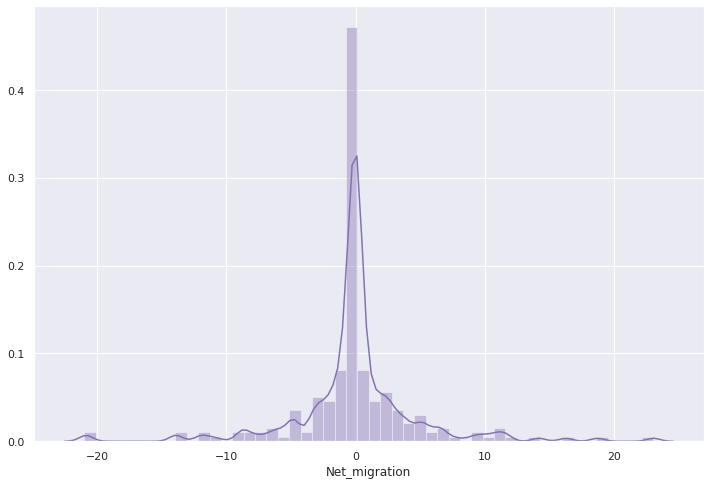

In [17]:
#Visualização utilizando histograma:
sns.distplot(countries['Net_migration'], color='m');

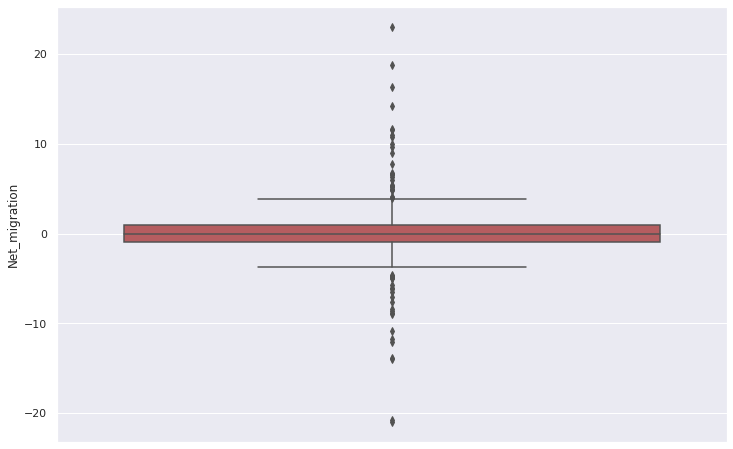

In [18]:
#Visualização utilizando boxplot:
ax = sns.boxplot(countries['Net_migration'], orient='vertical',color='r');

Temos algumas opções para tratar os outliers:

* Podemos eliminá-los da nossa amostra;
* Podemos analisá-los de forma separada,
* Podemos realizar alguma transformação matemática para reduzir a variação dos dados.

* O intervalo interquartil é uma medida de dispersão utilizada em estatística descritiva. Seu cálculo se da pela subtração do 3° quartil pelo 1° quartil. 

* POdemos considerar como outliers os valores menores que ```Q1-1,5*IQR``` ou valores maiores que ```Q3+1,5*IQR```.

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [19]:
# Carregando as categorias e o dataset newsgroups:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=1991)

In [20]:
def q6():
    """Counting the no of times each word(Unigram) appear in document."""

    # Iniciando o CountVectorizer:
    count_vectorizer = CountVectorizer()

    # Ajustando e transformando os dados:
    newsgroups_counts = count_vectorizer.fit_transform(newsgroup.data)

    # Número de vezes que a palavra phone aparece no corpus:
    return int(newsgroups_counts[:, count_vectorizer.vocabulary_['phone']].sum())
q6()

213

O **CountVectorizer** converter uma coleção de documentos de texto em uma matriz de contagens de tokens. Se não fornecermos uma coleção a priori e não usar um analisador que faça algum tipo de seleção de recurso, o número de recursos será igual ao tamanho do vocabulário encontrado ao analisar os dados.

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [21]:
def q7():
    """Sorting words in a collection of documents with the TF-IDF."""
    # Instanciado o TfidfVectorizer:
    tfidf_vectorizer = TfidfVectorizer()

    # Ajustando e transformando os dados:
    newsgroups_counts = tfidf_vectorizer.fit_transform(newsgroup.data)

    # TF-IDF da palavra phone:
    return np.round(float((newsgroups_counts[:, tfidf_vectorizer.vocabulary_['phone']].sum())),3)
q7()

8.888

O TF-IDF é usado para pontuar a importância de uma palavra em um documento com base na frequência com que ela apareceu nesse documento.

* **TF =** (número de vezes que o termo aparece em um documento) / (número de termos no documento)

* **IDF =** log (N / n), em que N é o número de documentos e n é o número de documentos em que um termo apareceu.